In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

# Part 1 Get the 15 miles buffer in Census Blocks

<AxesSubplot:>

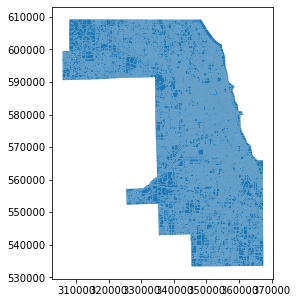

In [10]:
#read cook county shapefile and US shapefile
Cook_Boundaries_gdf = gpd.read_file('data/Census2010/CookCountyBlocks/Blocks.shp')
#project these two shapefiles
Cook_Boundaries_gdf_prj= Cook_Boundaries_gdf.to_crs('EPSG:26971')
fig,ax=plt.subplots(figsize=(5,5))
Cook_Boundaries_gdf_prj.plot(ax=ax)

<AxesSubplot:>

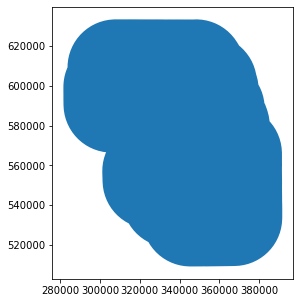

In [11]:
#make buffer for cook
Cook_Boundaries2010_Buffer_gdf=gpd.GeoDataFrame()
#Cook_Boundaries2010_Buffer_gdf['geometry']=Cook_Boundaries_gdf_prj.geometry.buffer(32186.9)#20mi
Cook_Boundaries2010_Buffer_gdf['geometry']=Cook_Boundaries_gdf_prj.geometry.buffer(24140.2)#15mi

#Merge all polygon into one
Cook_Boundaries2010_Buffer_gdf['new_column'] = 0
Cook_Boundaries2010_Buffer_gdf = Cook_Boundaries2010_Buffer_gdf.dissolve(by='new_column')
#plot results
fig,ax=plt.subplots(figsize=(5,5))
Cook_Boundaries2010_Buffer_gdf.plot(ax=ax)

In [12]:
#merge three censu blocks into one
IL_CensusBlocks_2010_gdf = gpd.read_file('data/Census2010/IL_Block10/IL_Block10.shp')
IN_CensusBlocks_2010_gdf = gpd.read_file('data/Census2010/IN_Block10/IN_Block10.shp')
WI_CensusBlocks_2010_gdf = gpd.read_file('data/Census2010/WI_Block10/WI_Block10.shp')
merged_gdf = gpd.GeoDataFrame(pd.concat( [IL_CensusBlocks_2010_gdf,IN_CensusBlocks_2010_gdf,WI_CensusBlocks_2010_gdf], ignore_index=True) )
merged_gdf.shape

(971721, 16)

<AxesSubplot:>

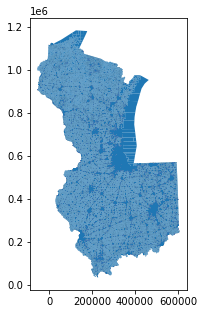

In [13]:
#project the merged data
fig,ax=plt.subplots(figsize=(5,5))
merged_gdf.crs = ('epsg:4326')
merged_gdf_prj = merged_gdf.to_crs('EPSG:26971')
merged_gdf_prj.plot(ax=ax)

<AxesSubplot:>

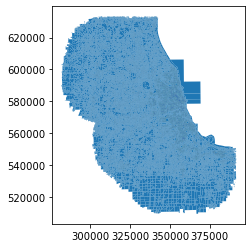

In [14]:
#get the buffer for merged census blocks
Cook_Boundaries2010_Buffer_polygon=Cook_Boundaries2010_Buffer_gdf.geometry[0]
Cook_Boundaries2010_Buffer_Doctors_in_buffer_gdf = merged_gdf_prj[merged_gdf_prj.within(Cook_Boundaries2010_Buffer_polygon)]

Cook_Boundaries2010_Buffer_Doctors_in_buffer_gdf.plot()

#

In [15]:
Cook_Boundaries2010_Buffer_Doctors_in_buffer_gdf.to_file(driver = 'ESRI Shapefile', filename= "Results/Cook_Boundaries2010_Buffer_blocks_15mi.shp")

/Users/yaxiongshao/opt/miniconda3/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Part 2 Aggreated doctor from point level to Census Blocks Level

In [16]:
doc_df= pd.read_csv('data/doctor_in_buffer_15mi.csv')
doc_df['geometry'] = doc_df.apply(lambda row: Point(row.lon, row.lat), axis=1)
doc_df.drop(columns=['lat','lon'], inplace=True)
doc_gdf = gpd.GeoDataFrame(doc_df,crs=('epsg:4269'))
doc_gdf_prj= doc_gdf.to_crs('EPSG:26971')
doc_gdf_prj.head()

/Users/yaxiongshao/opt/miniconda3/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,doc,id,geometry
0,2,1000,POINT (374435.201 513628.352)
1,1,1001,POINT (376410.645 513782.124)
2,2,1002,POINT (377156.019 513801.101)
3,2,1003,POINT (376585.963 513839.504)
4,1,1004,POINT (376386.776 514459.406)


<AxesSubplot:>

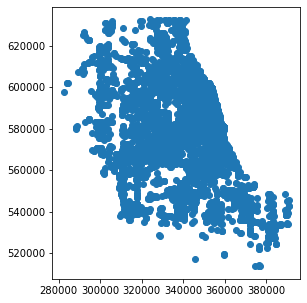

In [17]:

fig,ax=plt.subplots(figsize=(5,5))
doc_gdf_prj.plot(ax=ax)

In [18]:
sjoined_listings = gpd.sjoin(doc_gdf_prj,Cook_Boundaries2010_Buffer_Doctors_in_buffer_gdf, op='intersects')
#sjoined_listings.drop(["index_right","lat_right","lon_right"],axis=1,inplace=True)
#sjoined_listings["uid"]= sjoined_listings.index+100000
sjoined_listings.head()

/Users/yaxiongshao/opt/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3337: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,doc,id,geometry,index_right,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10
0,2,1000,POINT (374435.201 513628.352),581757,18,089,043401,1014,180890434011014,Block 1014,G5040,R,None,None,S,655603,0,+41.2973329,-087.4470707
1,1,1001,POINT (376410.645 513782.124),587548,18,089,043403,1014,180890434031014,Block 1014,G5040,U,51796,C,S,11648,0,+41.2911625,-087.4208488
2,2,1002,POINT (377156.019 513801.101),579053,18,089,043403,3037,180890434033037,Block 3037,G5040,U,51796,C,S,19768,0,+41.2921645,-087.4126614
3,2,1003,POINT (376585.963 513839.504),586755,18,089,043403,1021,180890434031021,Block 1021,G5040,U,51796,C,S,23163,0,+41.2923665,-087.4185437
4,1,1004,POINT (376386.776 514459.406),584410,18,089,043403,1004,180890434031004,Block 1004,G5040,U,51796,C,S,210103,0,+41.2988030,-087.4227837


In [19]:
print(Cook_Boundaries2010_Buffer_Doctors_in_buffer_gdf.shape, doc_gdf_prj.shape, sjoined_listings.shape)

(166980, 16) (7483, 3) (7483, 19)


<AxesSubplot:>

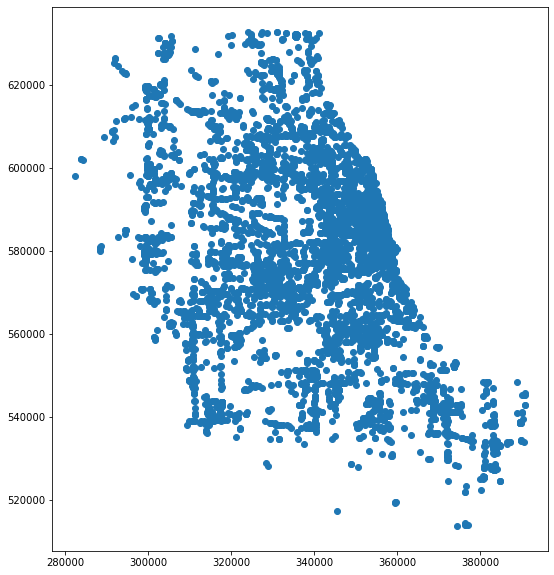

In [21]:
fig,ax=plt.subplots(figsize=(10,10))
sjoined_listings.plot(ax=ax)

In [23]:
temp2=sjoined_listings.groupby('GEOID10')['doc'].sum().reset_index()
temp2.columns=['geoid','doc']
temp2.head()

,geoid,doc
0,170310101002010,2
1,170310101003010,1
2,170310102021003,5
3,170310103002007,1
4,170310105031015,3


In [25]:
temp2.to_csv('Results/cookcounty_15mi_blocks_doc.csv',index=False)
sjoined_listings.to_file('Results/CookCounty_15mi_Blocks_Doc.shp')

/Users/yaxiongshao/opt/miniconda3/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/7s/gg08bxbn5_lgc58vh1jbwxs00000gn/T/ipykernel_74354/3492047080.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sjoined_listings.to_file('Results/CookCounty_15mi_Blocks_Doc.shp')


## Replace Index to reduce the data process size 

In [26]:
import polars as pl
index_df=pl.read_csv("17031-Block-Car-OD-index_166987_V2.csv")
index_df = index_df.select(
    [
        pl.col("geoid"),
        pl.col("id"),
    ]
)
index_df.head()

geoid,id
i64,i64
170310101001000,1
170310101001001,2
170310101001002,3
170310101001003,4
170310101002000,5


In [27]:
df=pl.read_csv("Results/cookcounty_15mi_blocks_doc.csv")
df=df.join(index_df,left_on="geoid",right_on="geoid")

df=df.select([
        pl.col("id"),
        pl.col("doc"),
])
print(df.shape)
df.to_csv("Results/cookcounty_15mi_blocks_doc_indexreplaced.csv")

(5018, 2)
